#### Mounting Google Drive to Colab Notebook


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Importing Dependencies

In [2]:
!python -m pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import math
pd.set_option('display.max_columns', None)
import numpy as np
pd.options.plotting.backend = "plotly"
import plotly.express as px
# pd.options.display.float_format = '{:20,.2f}'.format
# %matplotlib inline
from pandas.plotting import autocorrelation_plot
import tensorflow as tf
# from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
# from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Reading the Data

In [4]:
bank = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cash Forecasting/1001_ar_bank.csv', low_memory=False)

# Bank Data

## Preprocessing

In [5]:
print(f'dimensions : {bank.shape}')
bank.sample(5)

dimensions : (1049, 2)


,effective_date,amt
1011,2021-12-22,16125490.04
542,2020-02-27,29982419.25
877,2021-06-15,15561502.40
35,2018-02-22,15315624.31
48,2018-03-13,11292180.10


In [6]:
# Converting date into pandas datetime format
bank['effective_date'] = pd.to_datetime(bank['effective_date'])

In [7]:
# adding day_number and year to the dataframe

bank['day_number'] = bank['effective_date'].dt.dayofyear
bank['year'] = bank['effective_date'].dt.year
bank['week_number'] = bank['effective_date'].dt.strftime('%U')
bank['month'] = bank['effective_date'].dt.month

In [8]:
# To trim out extreme amount values

quantile_3 = bank['amt'].quantile(0.75)
print(f'3rd quantile : {quantile_3}')
quantile_1 = bank['amt'].quantile(0.25)
print(f'1st quantile : {quantile_1}')
iqr = quantile_3 - quantile_1
print(f'IQR: {iqr}')
lower_limit = quantile_1 - (1.5*iqr)
print(f'Lower limit: {lower_limit}')
upper_limit = quantile_3 + (1.5*iqr)
print(f'Upper limit: {upper_limit}')


### Trimming out the outliers
bank_new = bank[(bank['amt'] >= lower_limit)&(bank['amt'] <= upper_limit)]

3rd quantile : 29331172.99000001
1st quantile : 14525238.44
IQR: 14805934.55000001
Lower limit: -7683663.385000015
Upper limit: 51540074.81500003


In [9]:
# Train Test Validation Split
# We will take a 85:10:5 split of Train:validation:Test 

bank_train = bank_new[:int(bank_new.shape[0]*0.85)]
bank_val = bank_new[int(bank_new.shape[0]*0.85): int(bank_new.shape[0]*0.95)]
bank_test = bank_new[int(bank_new.shape[0]*0.95):]

## Observations

3 important things to notice
1. Trends : continuous increases or decreases in a metric's value
2. Seasonality : reflects periodic (cyclical) patterns that occur in a system
3. Residual - This is what remains of the time series after the trend and seasonality are removed.

In [10]:
fig = px.line(bank_train, x="effective_date", y="amt", title='bank Trend')
fig.show()

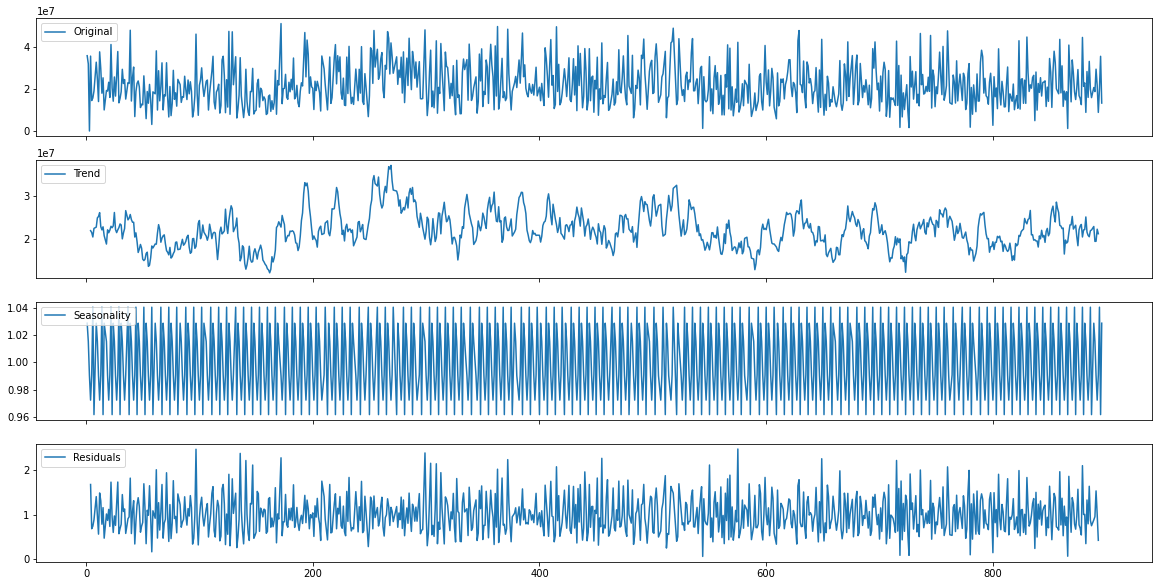

In [11]:
ts_dicomposition = seasonal_decompose(x=bank_train['amt'], model='multiplicative', freq=7)
trend_estimate = ts_dicomposition.trend
seasonal_estimate = ts_dicomposition.seasonal
residual_estimate = ts_dicomposition.resid
# Plotting the time series and it's components together
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(20)
# First plot to the Original time series
axes[0].plot(bank_train['amt'], label='Original') 
axes[0].legend(loc='upper left');
# second plot to be for trend
axes[1].plot(trend_estimate, label='Trend')
axes[1].legend(loc='upper left');
# third plot to be Seasonality component
axes[2].plot(seasonal_estimate, label='Seasonality')
axes[2].legend(loc='upper left');
# last last plot to be Residual component
axes[3].plot(residual_estimate, label='Residuals')
axes[3].legend(loc='upper left');

### Year-On-Year Graphs

We will see the daily, weekly, and monthly transactions over all the years, and visually try and identify any patterns/noises

In [12]:
# YoY Graph on a daily basis

bank_yoy = pd.pivot_table(bank_new, values='amt', index='day_number', columns='year', aggfunc='sum')
fig = bank_yoy.plot(title='Bank YoY Graph on a daily basis', labels=dict(value="log(money)"))
fig.update_yaxes(tickprefix="$")

While predicting on a daily basis might be a huge advantage for the company, we can clearly see the noise that happens on a daily basis, and therefore the prediction that we will expect will be very unrealiable.

In [13]:
# YoY Graph on a weekly basis

bank_yoy = pd.pivot_table(bank_new, values='amt', index='week_number', columns='year', aggfunc='sum')
fig = bank_yoy.plot(title='Bank YoY Graph on a weekly basis', labels=dict(value="log(money)"))
fig.update_yaxes(tickprefix="$")

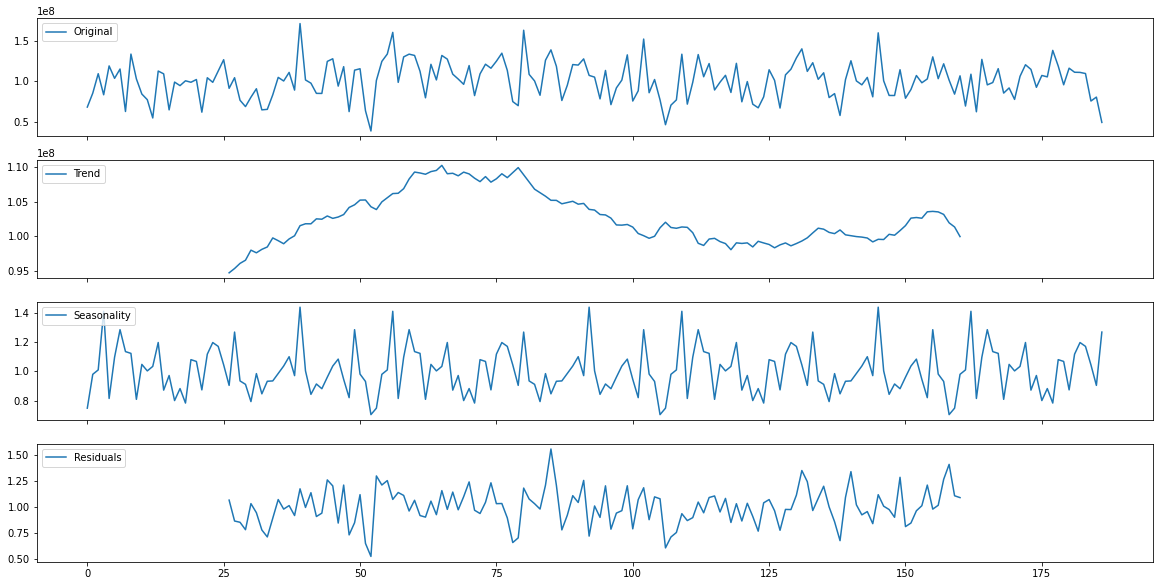

In [14]:
weekly_trend = np.array(bank_train.groupby(['year', 'week_number'])['amt'].sum())
ts_dicomposition = seasonal_decompose(x=weekly_trend, model='multiplicative', freq=53)
trend_estimate = ts_dicomposition.trend
seasonal_estimate = ts_dicomposition.seasonal
residual_estimate = ts_dicomposition.resid
# Plotting the time series and it's components together
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(20)
# First plot to the Original time series
axes[0].plot(weekly_trend, label='Original') 
axes[0].legend(loc='upper left');
# second plot to be for trend
axes[1].plot(trend_estimate, label='Trend')
axes[1].legend(loc='upper left');
# third plot to be Seasonality component
axes[2].plot(seasonal_estimate, label='Seasonality')
axes[2].legend(loc='upper left');
# last last plot to be Residual component
axes[3].plot(residual_estimate, label='Residuals')
axes[3].legend(loc='upper left');

We can already see a huge reduction in noise levels compared with the daily changes. <br>
There are also multiple visible patterns.<br>
So it might be best to work on a week level basis, and give the prediction for the entire week.<br>
While not as useful as the daily prediction, they will be hugely more reliable

In [15]:
# YoY Graph on a monthly basis

bank_yoy = pd.pivot_table(bank_new, values='amt', index='month', columns='year', aggfunc='sum')
fig = bank_yoy.plot(title='Bank YoY Graph on a mothly basis', labels=dict(value="log(money)"))
fig.update_yaxes(tickprefix="$")

Monthly changes have even less noise than the week level transactions, but they might not be very useful for the company. So predicting on a monthly basis, while easy, would not be very important for the company

## Baseline Model with Median Growth Rate

We're setting the base model, which is the simplest model we can think of. <br>We will predict amounts for 2022 and check the accuracy.

The complex ML models we use after this should perform better than this. Based on the complexity of the model, the accuracies, and the time taken to make the predictions, we should then decide whether it's even worth the companies time to proceed with the deployment of the model.
Complex models are often harder to explain and implement

In [16]:
bank_yoy = pd.pivot_table(bank_new, values='amt', index='week_number', columns='year', aggfunc='sum')
bank_yoy.dropna(subset = [2021], inplace=True)

bank_yoy['gr_18-19'] = bank_yoy[2019]/bank_yoy[2018]
bank_yoy['gr_19-20'] = bank_yoy[2020]/bank_yoy[2019]
bank_yoy['gr_20-21'] = bank_yoy[2021]/bank_yoy[2020]


bank_yoy['median_gr'] = np.median([bank_yoy['gr_18-19'], bank_yoy['gr_19-20'], bank_yoy['gr_20-21']])

# Dropping the individual growth_rates for a cleaner look
bank_yoy.drop(['gr_18-19', 'gr_19-20', 'gr_20-21'], axis=1, inplace=True)

# Making Predictions using the median_gr
bank_yoy['2022_pred'] = bank_yoy[2021]*bank_yoy['median_gr']

bank_yoy.head(10)

year,2018,2019,2020,2021,2022,median_gr,2022_pred
week_number,,,,,,,
01,8.532757e+07,1.247778e+08,7.047681e+07,8.415995e+07,1.212101e+08,0.983141,8.274107e+07
02,1.095048e+08,1.339020e+08,7.700862e+07,1.068532e+08,1.216296e+08,0.983141,1.050517e+08
03,8.335481e+07,1.607812e+08,1.336862e+08,6.938245e+07,1.020729e+08,0.983141,6.821271e+07
04,1.191617e+08,9.876287e+07,7.175659e+07,1.088744e+08,1.018541e+08,0.983141,1.070389e+08
05,1.037669e+08,1.303588e+08,9.889662e+07,6.226126e+07,8.673379e+07,0.983141,6.121158e+07
06,1.153143e+08,1.337665e+08,1.332366e+08,1.272572e+08,1.040393e+08,0.983141,1.251117e+08
07,6.261033e+07,1.321500e+08,1.057199e+08,9.564583e+07,2.344640e+07,0.983141,9.403331e+07
08,1.338320e+08,1.124710e+08,1.221071e+08,9.855524e+07,NaN,0.983141,9.689366e+07
09,1.030482e+08,7.960006e+07,8.930208e+07,1.157589e+08,NaN,0.983141,1.138072e+08


We can already see a big difference in week 4. <br> Investigating the reason of the large difference..

In [17]:
temp_bank = bank[(bank['week_number']=='07')&(bank['year']==2022)]
temp_bank

,effective_date,amt,day_number,year,week_number,month
1048,2022-02-14,23446403.18,45,2022,07,2


This is because the entire week hasn't been captured yet, and only one day was recorded.

In [18]:
#Eliminating week 07
bank_yoy.drop('07', axis='index', inplace=True)

In [19]:
# loss Calculation
bank_yoy.dropna(inplace=True)
loss = np.sqrt(np.sum(np.power(bank_yoy['2022_pred']-bank_yoy[2022], 2))/bank_yoy.shape[0])
print(f'RMSE : {loss}')

RMSE : 25895683.817592368


## Prophet

In [20]:
df = pd.DataFrame({'ds': bank_train['effective_date'], 'y': bank_train['amt']})
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=len(bank_val))
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

07:22:15 - cmdstanpy - INFO - Chain [1] start processing
07:22:15 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
950,2021-10-17,-8.228849e+05,-1.309515e+07,1.039529e+07
951,2021-10-18,2.264956e+07,1.044358e+07,3.339128e+07
952,2021-10-19,1.409531e+07,2.977217e+06,2.604324e+07
953,2021-10-20,1.537678e+07,3.444078e+06,2.685142e+07
954,2021-10-21,1.674446e+07,5.940554e+06,2.826646e+07


In [21]:
forecast = forecast[['ds', 'yhat']]
forecast = forecast.rename(columns={'ds': 'effective_date'})

In [22]:
prophet = bank_val.merge(forecast, how='inner')
prophet.head()

,effective_date,amt,day_number,year,week_number,month,yhat
0,2021-07-14,23939577.88,195,2021,28,7,1.808645e+07
1,2021-07-15,5455485.64,196,2021,28,7,1.946465e+07
2,2021-07-16,24839368.32,197,2021,28,7,2.374956e+07
3,2021-07-19,27718861.23,200,2021,29,7,2.330711e+07
4,2021-07-20,11618664.00,201,2021,29,7,1.478441e+07


In [23]:
rmse = np.sqrt(np.sum(np.power((prophet['amt'] - prophet['yhat']), 2))/forecast.shape[0])
print(rmse)

2050424.7324572662


## LSTM

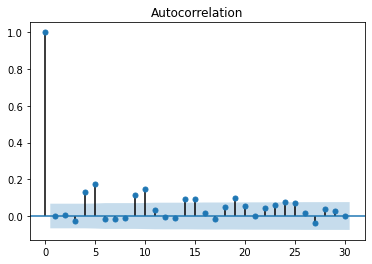

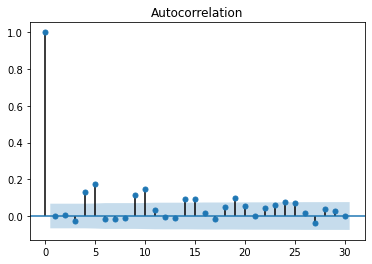

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(bank_train['amt'])

In [25]:
def sampling(sequence, n_steps):
    X, Y = list(), list()
    for i in range(len(sequence)):
        sam = i + n_steps
        if sam > len(sequence)-1:
            break
        x, y = sequence[i:sam], sequence[sam]
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

In [26]:
n_steps = 30
X, Y = sampling(bank_train['amt'].tolist(), n_steps)

In [27]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [28]:
X = X.reshape((X.shape[0], X.shape[1], 1))

In [29]:
model.fit(X, Y, epochs=20, verbose=1)

Epoch 1/20
26/26 [==============================] - 2s 15ms/step - loss: 504467061473280.0000
Epoch 2/20
26/26 [==============================] - 0s 17ms/step - loss: 181182893391872.0000
Epoch 3/20
26/26 [==============================] - 0s 16ms/step - loss: 190674888556544.0000
Epoch 4/20
26/26 [==============================] - 0s 15ms/step - loss: 192654616821760.0000
Epoch 5/20
26/26 [==============================] - 0s 16ms/step - loss: 190943173017600.0000
Epoch 6/20
26/26 [==============================] - 0s 16ms/step - loss: 129699179134976.0000
Epoch 7/20
26/26 [==============================] - 1s 27ms/step - loss: 125847289724928.0000
Epoch 8/20
26/26 [==============================] - 1s 28ms/step - loss: 133162214621184.0000
Epoch 9/20
26/26 [==============================] - 1s 26ms/step - loss: 130655069405184.0000
Epoch 10/20
26/26 [==============================] - 1s 29ms/step - loss: 118742247800832.0000
Epoch 11/20
26/26 [==============================] - 1s 26m

In [30]:
np.sqrt(122530274738176)

11069339.39935785

In [31]:
X_val, Y_val = sampling(bank_val['amt'].tolist(), n_steps)

In [32]:
x = X_val.reshape((X_val.shape[0], n_steps, 1))

In [33]:
ypred = model.predict(x, verbose=1)

3/3 [==============================] - 0s 8ms/step


In [34]:
print(ypred.shape)

(70, 1)
